In [1]:
import autograd.numpy as np
from autograd.numpy import linalg
from autograd.numpy.random import poisson, normal, multivariate_normal
from autograd import grad
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt

Defining Negative Poisson GP likelihood function in terms of observed counts $n_i$, mean model $y_i$, mean $\mu_i$, signal $s_i$, and GP kernel $\Sigma_{ij}$, we have the function:

$l(n_i, y_i | \mu_i, s_i, \Sigma_{ij}) = -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} - \frac{1}{2} \left( (\vec{y} - \vec{\mu})^T \Sigma^{-1} (\vec{y} - \vec{\mu}) \right) + \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i)$

Split into terms:

$\begin{align*}
t1 &= -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} \text{(constants, Gaussian)}\\
t2 &= - \frac{1}{2} \left( (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right) \text{(Gaussian)}\\
t3 &= \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i) \text{(Poisson)}
\end{align*}$

In [2]:
def neg_log_like_PGP(mu, s, ni, y, cov, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    det = linalg.det(cov)
    t1 = -(N/2.)*np.log(2.*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (y-mu)[np.newaxis]
    t2 = (-(1./2) * np.dot(np.dot(resid,invcov),resid.T))[0][0]
    t3 = np.sum(ni * np.log(mu + s) - (mu + s))
    result =  t2 + t3# + t1
    #if t1-t2==t1 or t1-t3==t1:
       # result-=t1
    return -result               
    
neg_log_like_PGP_grad = grad(neg_log_like_PGP)

Setting the models:


$\begin{align*}
\mu_{true, i} &= \frac{1}{ln(x_i+1)}\\
y_i(\theta_{y}) &= \frac{a}{(b*x_i+c)^2}+d, \theta_{y} = \{ a,b,c,d\}\\
\Sigma_{ij}(\theta_{\Sigma}) &= A \lambda e^{-\frac{(x_i-x_j)^2}{l(x_i)^2+l(x_j)^2}+\frac{d-(x_i+x_j)}{(2.*a))}}, l(x) = bx + c, \lambda = \sqrt{\frac{2l(x_i)l(x_j)}{l(x_i)^2+l(x_j)^2}}, \theta_{\Sigma} = \{A, a , b, c, d \}
\end{align*}$


In [3]:
def true_mu(x):
    return 1./np.log(1.5*x+1)

def y_model(x):
    return 1./(np.power(x+.3,2))

def y_opt(x, params):
    a, b, c, d = params
    return ((1.*a)/(np.power(b*x + c,2)))+d

def y_preopt(x, a, b, c, d):
        params = np.array([a,b,c,d])
        return y_opt(x, params)
    
class mean_model(object):
    def __init__(self, f, params):
        self.f = f
        self.params = params
        self.frozen = True
    def get_value(self, x):
        return self.f(x, self.params)
    def freeze_all_parameters(self):
        self.frozen = True


def kernel_func_exp(x1,x2, params):
    A = params[0]
    l = params[1]

    result = A * np.exp(-np.power((x1-x2),2)/(l**2))
    return result

def kernel_func_gibbs(x1,x2, params):
    A = params[0]
    a = params[1]
    b = params[2]
    c = params[3]
    d = params[4]
    l1 = (b * x1) + c
    l2 = (b * x2) + c
    lam = np.sqrt((2*l1*l2)/((l1**2)+(l2**2)))
    result = A * lam * np.exp(-(((x1-x2)**2)/((l1**2)+(l2**2)))+((d-(x1+x2))/(2.*a)))
    return result

#expkernel = ge.kernels.PythonKernel(kernel_func_exp, pars= [5., .5])

def make_kernel(x, k, params):
    N = len(x)
    cov = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    return cov

def predict(t, n, y, cov, sigma):
    N = len(t)
    p_dist = np.empty(N)
    v_dist = np.empty(N)
    for i in range(N):
        inv = linalg.inv(cov+np.diag(np.power(sigma,2)))
        p_dist[i] = y[i] + cov[i].T.dot(inv.dot(n-y))
        v_dist[i] = cov[i][i] - cov[i].T.dot(inv.dot(cov[i]))
        if np.isnan(v_dist[i]):
            print ("NAN, cov diag = " + str(cov[i][i]) + "\t other term: " + str(cov[i].T.dot(inv.dot(cov[i]))))
    return p_dist, v_dist

Sample the fits 100 times:

In [47]:
#initializing true mu and storage arrays
Nit = 5000
N = 30
scale = 5.
params_test = [ 1.31655222e+04, -3.86589690e+01, -1.39470218e+01,  2.05448447e+00]
t = np.linspace(.5, 10, N)
mu_test = scale* true_mu(t)
options={'ftol' :  np.finfo(float).eps, 'maxfun': 1.5e5, 'maxiter': 1.5e5, 'gtol': np.finfo(float).eps}

arrays = [n_array, mu_GP_array, mu_PGP_array, resid_array, ratio_array]

for array in arrays:
    try:
        array
    except NameError:
        array = []
        
#sample NIt times
for k in range(Nit):
    print(str((100.*k)/Nit) + "% complete")
    n_test = poisson(mu_test)
    n_err = np.sqrt(n_test)
    n_array.append(n_test)
    
    
    #optimizing model parameters
    try:
        popt, pcov = curve_fit(y_preopt, t, n_test, p0=[params_test], maxfev=10000)
    except RuntimeError:
        continue
    params_test = popt
    model_test = y_opt(t, params_test)
    s_test = np.zeros(N)
    boundarray = [(1e-2,None) for i in range(N)]
    cov_PGP = make_kernel(t, kernel_func_gibbs, [1, 3., .1, 0., 10.])
    
    #predictive analysis (gaussian)
    pred, pred_var = predict(t, n_test, model_test, cov_PGP, np.sqrt(n_test))
    pred_unc = np.sqrt(pred_var)
    mu_GP_array.append(pred)
    
    
    #PGP fit
    soln_PGP = minimize(neg_log_like_PGP, model_test,  method="L-BFGS-B", args = (s_test, n_test, model_test, cov_PGP), options = options, bounds = boundarray)
    PGP_fit = soln_PGP.x
    PGP_fit_unc = np.sqrt(np.diag(soln_PGP.hess_inv.matmat(np.eye(N))))
    mu_PGP_array.append(PGP_fit)
    
    resid_array.append(PGP_fit - pred)
    ratio_array.append(PGP_fit / pred)
    
    

0.0% complete
0.02% complete
0.04% complete
0.06% complete
0.08% complete


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in divide


0.1% complete
0.12% complete
0.14% complete
0.16% complete
0.18% complete
0.2% complete
0.22% complete
0.24% complete
0.26% complete
0.28% complete
0.3% complete
0.32% complete
0.34% complete
0.36% complete
0.38% complete
0.4% complete
0.42% complete
0.44% complete
0.46% complete
0.48% complete
0.5% complete
0.52% complete
0.54% complete
0.56% complete
0.58% complete
0.6% complete
0.62% complete
0.64% complete
0.66% complete
0.68% complete
0.7% complete
0.72% complete
0.74% complete
0.76% complete
0.78% complete
0.8% complete
0.82% complete
0.84% complete
0.86% complete
0.88% complete
0.9% complete
0.92% complete
0.94% complete
0.96% complete
0.98% complete
1.0% complete
1.02% complete
1.04% complete
1.06% complete
1.08% complete
1.1% complete
1.12% complete
1.14% complete
1.16% complete
1.18% complete
1.2% complete
1.22% complete
1.24% complete
1.26% complete
1.28% complete
1.3% complete
1.32% complete
1.34% complete
1.36% complete
1.38% complete
1.4% complete
1.42% complete
1.44% com

11.1% complete
11.12% complete
11.14% complete
11.16% complete
11.18% complete
11.2% complete
11.22% complete
11.24% complete
11.26% complete
11.28% complete
11.3% complete
11.32% complete
11.34% complete
11.36% complete
11.38% complete
11.4% complete
11.42% complete
11.44% complete
11.46% complete
11.48% complete
11.5% complete
11.52% complete
11.54% complete
11.56% complete
11.58% complete
11.6% complete
11.62% complete
11.64% complete
11.66% complete
11.68% complete
11.7% complete
11.72% complete
11.74% complete
11.76% complete
11.78% complete
11.8% complete
11.82% complete
11.84% complete
11.86% complete
11.88% complete
11.9% complete
11.92% complete
11.94% complete
11.96% complete
11.98% complete
12.0% complete
12.02% complete
12.04% complete
12.06% complete
12.08% complete
12.1% complete
12.12% complete
12.14% complete
12.16% complete
12.18% complete
12.2% complete
12.22% complete
12.24% complete
12.26% complete
12.28% complete
12.3% complete
12.32% complete
12.34% complete
12.36

21.48% complete
21.5% complete
21.52% complete
21.54% complete
21.56% complete
21.58% complete
21.6% complete
21.62% complete
21.64% complete
21.66% complete
21.68% complete
21.7% complete
21.72% complete
21.74% complete
21.76% complete
21.78% complete
21.8% complete
21.82% complete
21.84% complete
21.86% complete
21.88% complete
21.9% complete
21.92% complete
21.94% complete
21.96% complete
21.98% complete
22.0% complete
22.02% complete
22.04% complete
22.06% complete
22.08% complete
22.1% complete
22.12% complete
22.14% complete
22.16% complete
22.18% complete
22.2% complete
22.22% complete
22.24% complete
22.26% complete
22.28% complete
22.3% complete
22.32% complete
22.34% complete
22.36% complete
22.38% complete
22.4% complete
22.42% complete
22.44% complete
22.46% complete
22.48% complete
22.5% complete
22.52% complete
22.54% complete
22.56% complete
22.58% complete
22.6% complete
22.62% complete
22.64% complete
22.66% complete
22.68% complete
22.7% complete
22.72% complete
22.74

31.86% complete
31.88% complete
31.9% complete
31.92% complete
31.94% complete
31.96% complete
31.98% complete
32.0% complete
32.02% complete
32.04% complete
32.06% complete
32.08% complete
32.1% complete
32.12% complete
32.14% complete
32.16% complete
32.18% complete
32.2% complete
32.22% complete
32.24% complete
32.26% complete
32.28% complete
32.3% complete
32.32% complete
32.34% complete
32.36% complete
32.38% complete
32.4% complete
32.42% complete
32.44% complete
32.46% complete
32.48% complete
32.5% complete
32.52% complete
32.54% complete
32.56% complete
32.58% complete
32.6% complete
32.62% complete
32.64% complete
32.66% complete
32.68% complete
32.7% complete
32.72% complete
32.74% complete
32.76% complete
32.78% complete
32.8% complete
32.82% complete
32.84% complete
32.86% complete
32.88% complete
32.9% complete
32.92% complete
32.94% complete
32.96% complete
32.98% complete
33.0% complete
33.02% complete
33.04% complete
33.06% complete
33.08% complete
33.1% complete
33.12

42.24% complete
42.26% complete
42.28% complete
42.3% complete
42.32% complete
42.34% complete
42.36% complete
42.38% complete
42.4% complete
42.42% complete
42.44% complete
42.46% complete
42.48% complete
42.5% complete
42.52% complete
42.54% complete
42.56% complete
42.58% complete
42.6% complete
42.62% complete
42.64% complete
42.66% complete
42.68% complete
42.7% complete
42.72% complete
42.74% complete
42.76% complete
42.78% complete
42.8% complete
42.82% complete
42.84% complete
42.86% complete
42.88% complete
42.9% complete
42.92% complete
42.94% complete
42.96% complete
42.98% complete
43.0% complete
43.02% complete
43.04% complete
43.06% complete
43.08% complete
43.1% complete
43.12% complete
43.14% complete
43.16% complete
43.18% complete
43.2% complete
43.22% complete
43.24% complete
43.26% complete
43.28% complete
43.3% complete
43.32% complete
43.34% complete
43.36% complete
43.38% complete
43.4% complete
43.42% complete
43.44% complete
43.46% complete
43.48% complete
43.5

52.62% complete
52.64% complete
52.66% complete
52.68% complete
52.7% complete
52.72% complete
52.74% complete
52.76% complete
52.78% complete
52.8% complete
52.82% complete
52.84% complete
52.86% complete
52.88% complete
52.9% complete
52.92% complete
52.94% complete
52.96% complete
52.98% complete
53.0% complete
53.02% complete
53.04% complete
53.06% complete
53.08% complete
53.1% complete
53.12% complete
53.14% complete
53.16% complete
53.18% complete
53.2% complete
53.22% complete
53.24% complete
53.26% complete
53.28% complete
53.3% complete
53.32% complete
53.34% complete
53.36% complete
53.38% complete
53.4% complete
53.42% complete
53.44% complete
53.46% complete
53.48% complete
53.5% complete
53.52% complete
53.54% complete
53.56% complete
53.58% complete
53.6% complete
53.62% complete
53.64% complete
53.66% complete
53.68% complete
53.7% complete
53.72% complete
53.74% complete
53.76% complete
53.78% complete
53.8% complete
53.82% complete
53.84% complete
53.86% complete
53.8

63.0% complete
63.02% complete
63.04% complete
63.06% complete
63.08% complete
63.1% complete
63.12% complete
63.14% complete
63.16% complete
63.18% complete
63.2% complete
63.22% complete
63.24% complete
63.26% complete
63.28% complete
63.3% complete
63.32% complete
63.34% complete
63.36% complete
63.38% complete
63.4% complete
63.42% complete
63.44% complete
63.46% complete
63.48% complete
63.5% complete
63.52% complete
63.54% complete
63.56% complete
63.58% complete
63.6% complete
63.62% complete
63.64% complete
63.66% complete
63.68% complete
63.7% complete
63.72% complete
63.74% complete
63.76% complete
63.78% complete
63.8% complete
63.82% complete
63.84% complete
63.86% complete
63.88% complete
63.9% complete
63.92% complete
63.94% complete
63.96% complete
63.98% complete
64.0% complete
64.02% complete
64.04% complete
64.06% complete
64.08% complete
64.1% complete
64.12% complete
64.14% complete
64.16% complete
64.18% complete
64.2% complete
64.22% complete
64.24% complete
64.26

73.38% complete
73.4% complete
73.42% complete
73.44% complete
73.46% complete
73.48% complete
73.5% complete
73.52% complete
73.54% complete
73.56% complete
73.58% complete
73.6% complete
73.62% complete
73.64% complete
73.66% complete
73.68% complete
73.7% complete
73.72% complete
73.74% complete
73.76% complete
73.78% complete
73.8% complete
73.82% complete
73.84% complete
73.86% complete
73.88% complete
73.9% complete
73.92% complete
73.94% complete
73.96% complete
73.98% complete
74.0% complete
74.02% complete
74.04% complete
74.06% complete
74.08% complete
74.1% complete
74.12% complete
74.14% complete
74.16% complete
74.18% complete
74.2% complete
74.22% complete
74.24% complete
74.26% complete
74.28% complete
74.3% complete
74.32% complete
74.34% complete
74.36% complete
74.38% complete
74.4% complete
74.42% complete
74.44% complete
74.46% complete
74.48% complete
74.5% complete
74.52% complete
74.54% complete
74.56% complete
74.58% complete
74.6% complete
74.62% complete
74.64

83.76% complete
83.78% complete
83.8% complete
83.82% complete
83.84% complete
83.86% complete
83.88% complete
83.9% complete
83.92% complete
83.94% complete
83.96% complete
83.98% complete
84.0% complete
84.02% complete
84.04% complete
84.06% complete
84.08% complete
84.1% complete
84.12% complete
84.14% complete
84.16% complete
84.18% complete
84.2% complete
84.22% complete
84.24% complete
84.26% complete
84.28% complete
84.3% complete
84.32% complete
84.34% complete
84.36% complete
84.38% complete
84.4% complete
84.42% complete
84.44% complete
84.46% complete
84.48% complete
84.5% complete
84.52% complete
84.54% complete
84.56% complete
84.58% complete
84.6% complete
84.62% complete
84.64% complete
84.66% complete
84.68% complete
84.7% complete
84.72% complete
84.74% complete
84.76% complete
84.78% complete
84.8% complete
84.82% complete
84.84% complete
84.86% complete
84.88% complete
84.9% complete
84.92% complete
84.94% complete
84.96% complete
84.98% complete
85.0% complete
85.02

94.14% complete
94.16% complete
94.18% complete
94.2% complete
94.22% complete
94.24% complete
94.26% complete
94.28% complete
94.3% complete
94.32% complete
94.34% complete
94.36% complete
94.38% complete
94.4% complete
94.42% complete
94.44% complete
94.46% complete
94.48% complete
94.5% complete
94.52% complete
94.54% complete
94.56% complete
94.58% complete
94.6% complete
94.62% complete
94.64% complete
94.66% complete
94.68% complete
94.7% complete
94.72% complete
94.74% complete
94.76% complete
94.78% complete
94.8% complete
94.82% complete
94.84% complete
94.86% complete
94.88% complete
94.9% complete
94.92% complete
94.94% complete
94.96% complete
94.98% complete
95.0% complete
95.02% complete
95.04% complete
95.06% complete
95.08% complete
95.1% complete
95.12% complete
95.14% complete
95.16% complete
95.18% complete
95.2% complete
95.22% complete
95.24% complete
95.26% complete
95.28% complete
95.3% complete
95.32% complete
95.34% complete
95.36% complete
95.38% complete
95.4

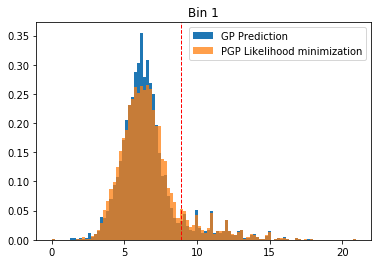

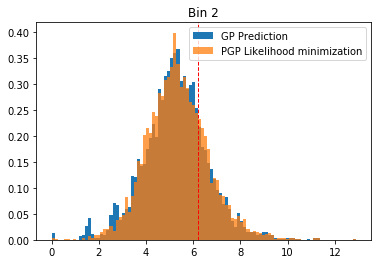

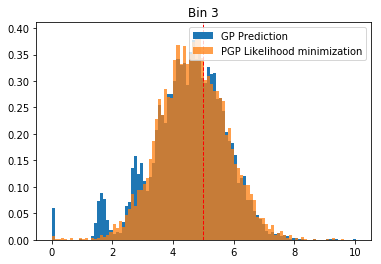

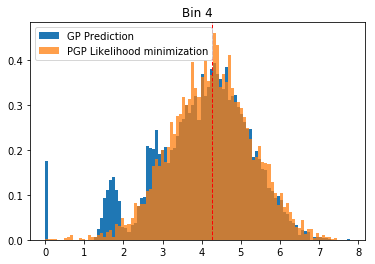

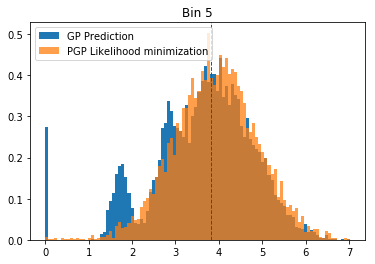

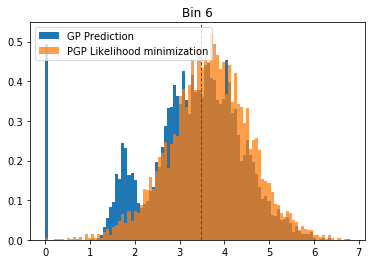

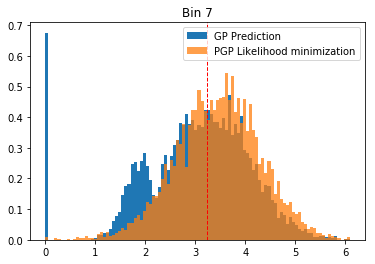

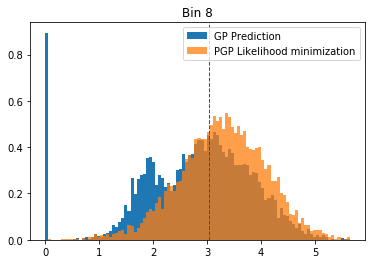

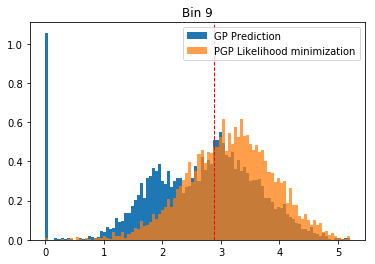

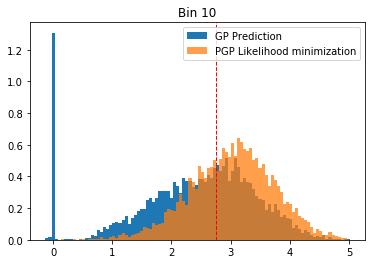

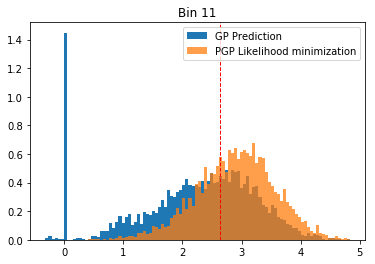

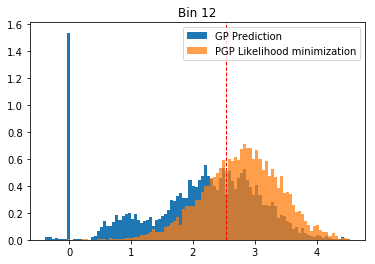

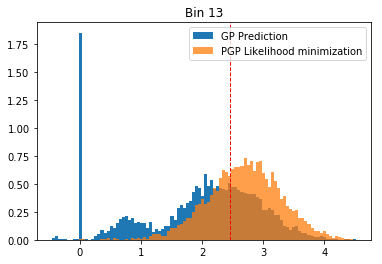

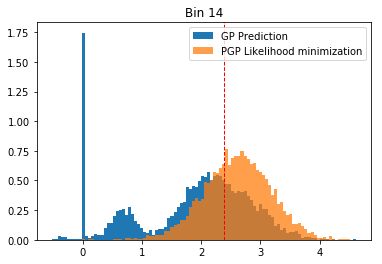

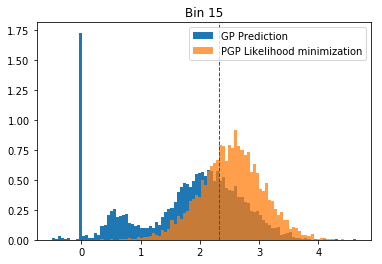

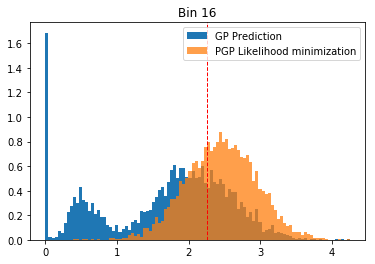

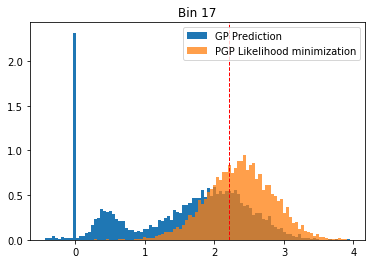

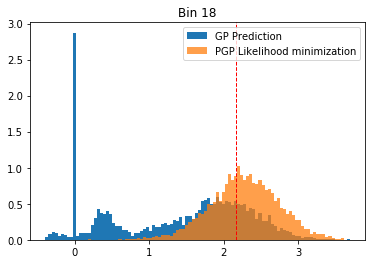

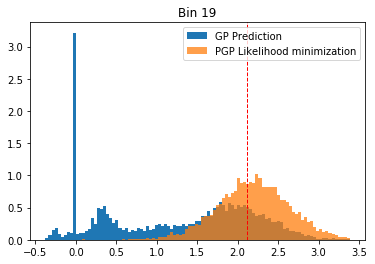

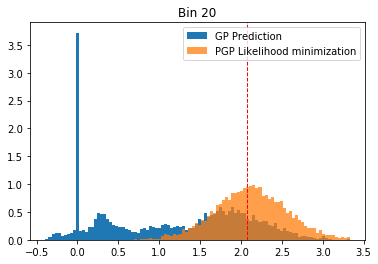

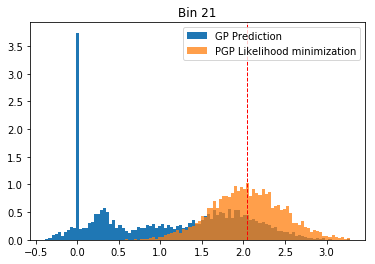

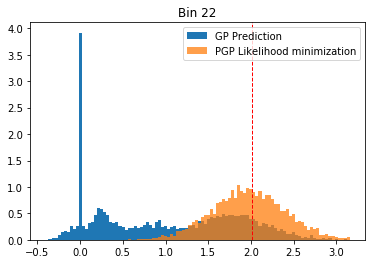

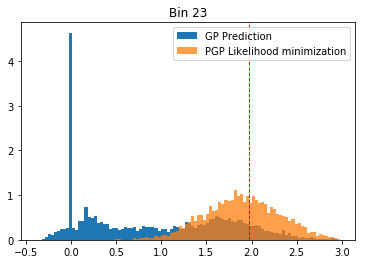

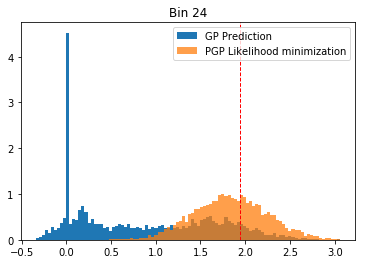

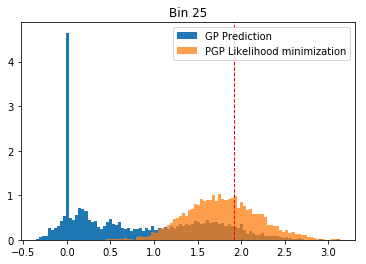

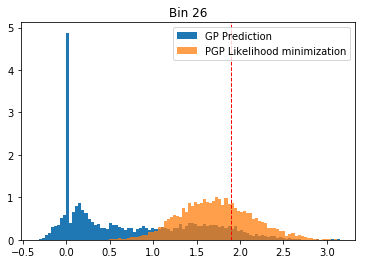

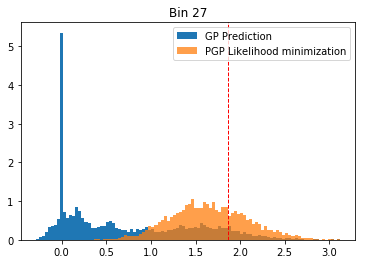

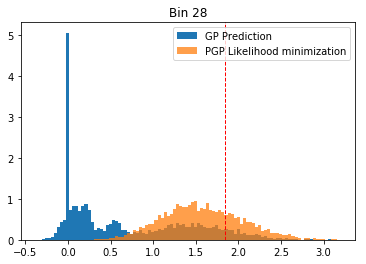

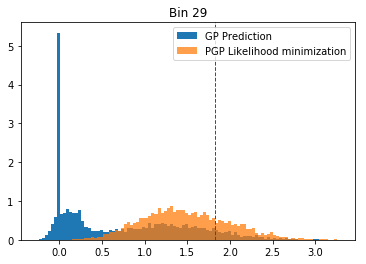

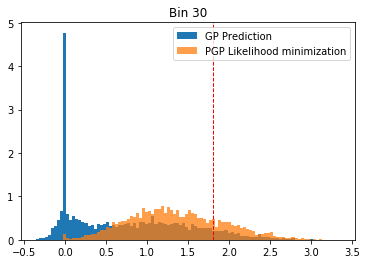

In [59]:

data_arrays = [mu_GP_array, mu_PGP_array]
arrays = [n_array, mu_GP_array, mu_PGP_array, resid_array, ratio_array]

GP_mean = np.empty(N)
GP_std = np.empty(N)
PGP_mean = np.empty(N)
PGP_std = np.empty(N)

for bindex in range(N):
    for atest in data_arrays:
        while i<len(atest):
            tval = np.array(atest)[i, bindex]
            if np.isnan(tval) or tval<0:
                "Value Deleted"
                for delarray in arrays:
                    del delarray[i]
            else:
                i = i + 1
    GP_mean[bindex] = np.mean(np.array(mu_GP_array)[:,bindex])
    GP_std[bindex] = np.std(np.array(mu_GP_array)[:,bindex])
    PGP_mean[bindex] = np.mean(np.array(mu_PGP_array)[:,bindex])
    PGP_std[bindex] = np.std(np.array(mu_PGP_array)[:,bindex])

    plt.figure()
    plt.title("Bin " + str(bindex + 1))
    _, bins, _ = plt.hist(np.array(mu_GP_array)[:,bindex], bins=100, normed = True, label = "GP Prediction")
    plt.hist(np.array(mu_PGP_array)[:,bindex], bins=bins, normed = True, alpha = .75, label = "PGP Likelihood minimization")
    plt.axvline(mu_test[bindex], color='k', linestyle='dashed', linewidth=1, label = "True $\mu$")
    plt.legend()
plt.show()

In [55]:
print len(mu_GP_array)

5352
